# Orbit Station-keeping with QLaw

In this notebook, we will show how to perform station keeping maneuvers using the QLaw Guidance Law.

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

from ostk.mathematics.geometry.d3.object import Cuboid
from ostk.mathematics.geometry.d3.object import Composite
from ostk.mathematics.geometry.d3.object import Point

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.environment.object.celestial import Earth
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.time import Instant
from ostk.physics.time import Scale
from ostk.physics.time import Time
from ostk.physics.unit import Length
from ostk.physics.unit import Mass
from ostk.physics.unit import Angle

from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.trajectory import Propagator
from ostk.astrodynamics.trajectory import StateBuilder
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory.state import CoordinateSubset
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianPosition
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianVelocity
from ostk.astrodynamics.trajectory.orbit.model.kepler import COE
from ostk.astrodynamics.dynamics import Thruster
from ostk.astrodynamics.guidance_law import QLaw
from ostk.astrodynamics.flight.system import SatelliteSystem
from ostk.astrodynamics.flight.system import PropulsionSystem

## User inputs

In [2]:
earth = Earth.from_models(
    EarthGravitationalModel(EarthGravitationalModel.Type.Spherical),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(EarthAtmosphericModel.Type.Undefined),
)

environment = Environment(Instant.J2000(), [earth])

In [4]:
dry_mass = Mass.kilograms(200.0)
propellant_mass = Mass.kilograms(14.0)
wet_mass = Mass.kilograms(dry_mass.in_kilograms() + propellant_mass.in_kilograms())
propulsion_system = PropulsionSystem(
    thrust_si_unit=1e-1, specific_impulse_si_unit=1000.0
)

## Setup environment, initial state and Satellite System

In [5]:
satellite_geometry = Composite(
    Cuboid(Point(0.0, 0.0, 0.0), np.eye(3).tolist(), [1.0, 0.0, 0.0])
)
satellite_system = SatelliteSystem(
    dry_mass, satellite_geometry, np.eye(3), 2.0, 2.2, propulsion_system
)

In [6]:
instant = Instant.date_time(DateTime(2024, 10, 1, 0, 0, 0), Scale.UTC)
orbit = Orbit.sun_synchronous(
    instant, Length.kilometers(585.0), Time(11, 0, 0), Earth.default()
)
initial_state = orbit.get_state_at(instant)
coe = COE.cartesian(
    (initial_state.get_position(), initial_state.get_velocity()),
    EarthGravitationalModel.EGM2008.gravitational_parameter,
)

In [7]:
state_builder = StateBuilder(
    frame=Frame.GCRF(),
    coordinate_subsets=[
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinateSubset.mass(),
    ],
)

coordinates = [
    *initial_state.get_coordinates().tolist(),
    wet_mass.in_kilograms(),
]

propagation_state = state_builder.build(initial_state.get_instant(), coordinates)

In [8]:
numerical_solver = NumericalSolver(
    NumericalSolver.LogType.NoLog,
    NumericalSolver.StepperType.RungeKutta4,
    2.0,
    1e-12,
    1e-12,
)

## Utility functions

In [9]:
def df_from_states(states, sample_size=30):
    data = []
    for state in states[::sample_size]:
        coe = COE.cartesian(
            (state.get_position(), state.get_velocity()),
            earth.get_gravitational_parameter(),
        )
        data.append(
            {
                "time": state.get_instant().get_date_time(Scale.UTC),
                "semi-major axis": float(coe.get_semi_major_axis().in_kilometers()),
                "eccentricity": float(coe.get_eccentricity()),
                "inclination": float(coe.get_inclination().in_degrees()),
                "right ascension of ascending node": float(coe.get_raan().in_degrees()),
                "wet mass": float(state.get_coordinates()[6]),
            }
        )

    df = pd.DataFrame(data)
    return df

## SMA targeting

In [10]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity(),
    coe.get_inclination(),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)

guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.SemiMajorAxis: (1.0, 50.0)},
        m=3,
        n=4,
        r=2,
        b=0.01,
        k=100,
        periapsis_weight=0.0,
        minimum_periapsis_radius=Length.kilometers(6578.0),
    ),
    QLaw.GradientStrategy.Analytical,
)

In [11]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [12]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(2.0),
)

In [13]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states(), 10)

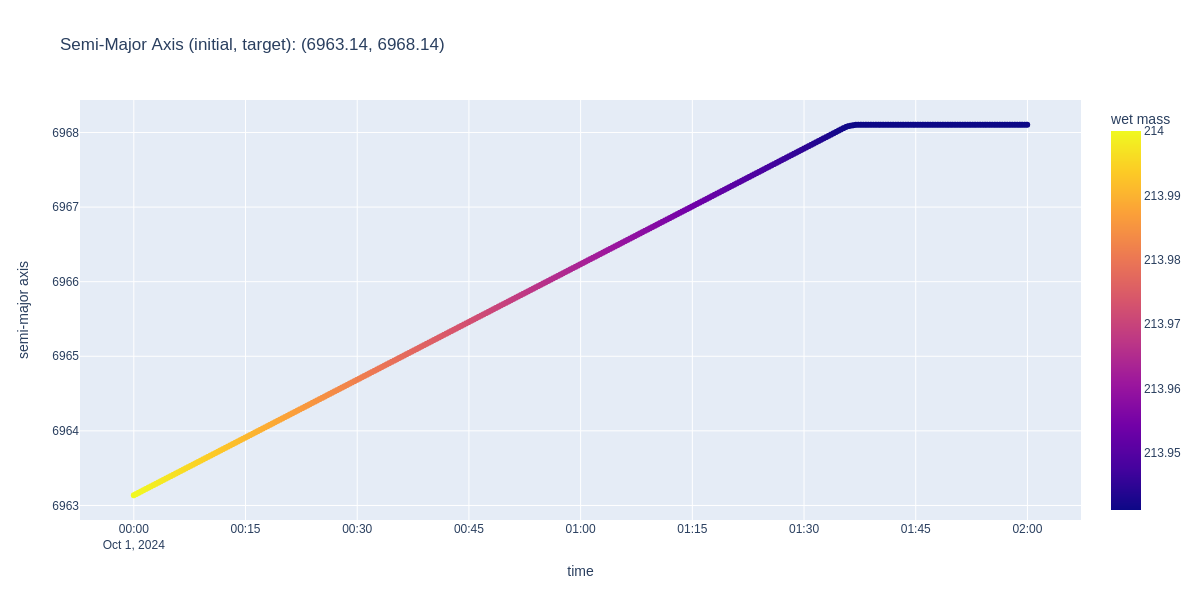

In [14]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="wet mass",
    title=f"Semi-Major Axis (initial, target): ({float(coe.get_semi_major_axis().in_kilometers()):.2f}, {float(target_coe.get_semi_major_axis().in_kilometers()):.2f})",
    height=600,
    width=1200,
)
figure.show("png")

### Eccentricity targeting

In [15]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis(),
    coe.get_eccentricity() + 1e-3,
    coe.get_inclination(),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.Eccentricity: (1.0, 1e-5)},
        m=3,
        n=4,
        r=2,
        k=100,
        periapsis_weight=0.0,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

In [16]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [17]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(3.0),
)

In [18]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states(), 10)

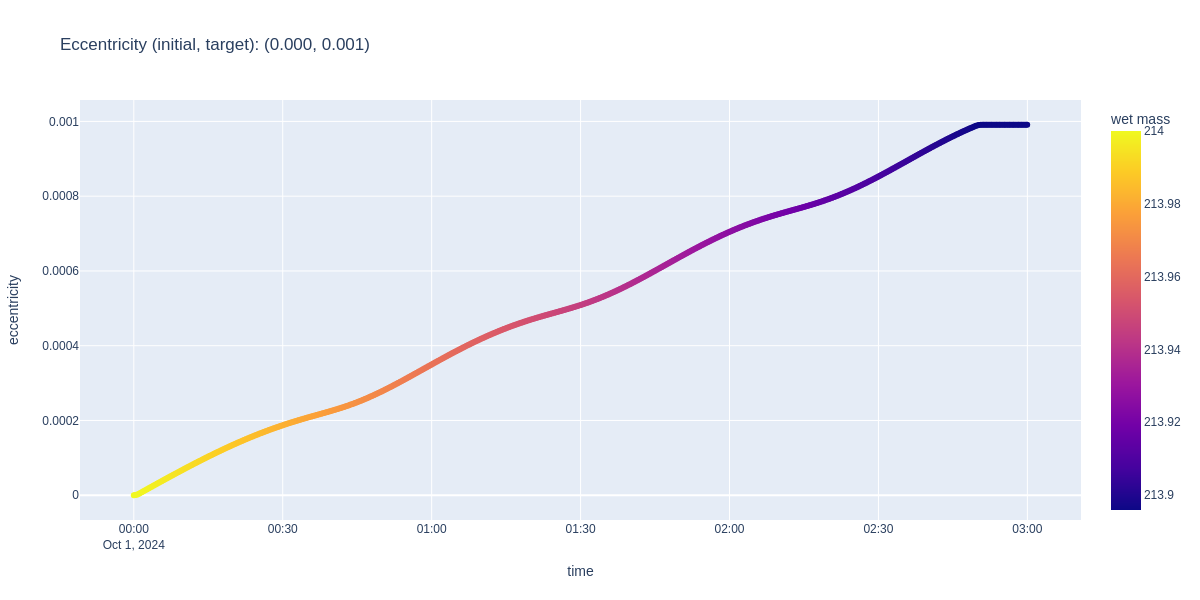

In [19]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="wet mass",
    title=f"Eccentricity (initial, target): ({float(coe.get_eccentricity()):.3f}, {float(target_coe.get_eccentricity()):.3f})",
    height=600,
    width=1200,
)
figure.show("png")

### Inclination targeting

In [20]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis(),
    coe.get_eccentricity(),
    coe.get_inclination() + Angle.degrees(5e-2),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.Inclination: (1.0, 1e-5)},
        m=3,
        n=4,
        r=2,
        k=100,
        periapsis_weight=0.0,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

In [21]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [22]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(7.0),
)

In [23]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

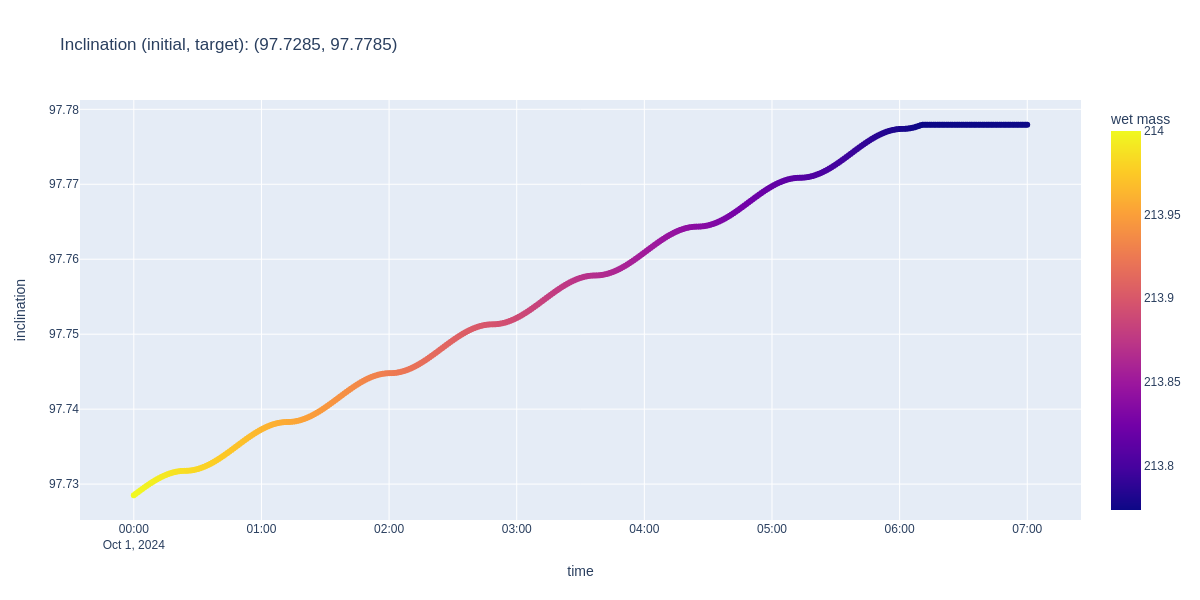

In [24]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="wet mass",
    title=f"Inclination (initial, target): ({float(coe.get_inclination().in_degrees()):.4f}, {float(target_coe.get_inclination().in_degrees()):.4f})",
    height=600,
    width=1200,
)
figure.show("png")

### Right Ascension of Ascending Node targeting

In [25]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis(),
    coe.get_eccentricity(),
    coe.get_inclination(),
    coe.get_raan() - Angle.degrees(1e-1),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={COE.Element.Raan: (1.0, 1e-6)},
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

In [26]:
dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [27]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(13.0),
)

In [28]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

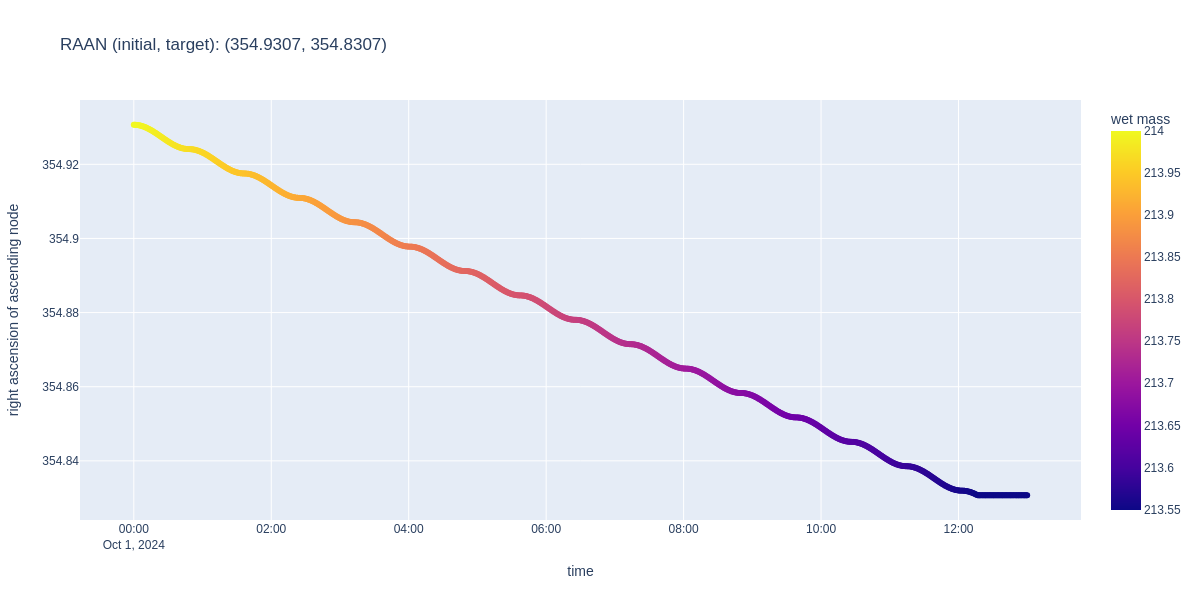

In [29]:
figure = px.scatter(
    df,
    x="time",
    y="right ascension of ascending node",
    color="wet mass",
    title=f"RAAN (initial, target): ({float(coe.get_raan().in_degrees()):.4f}, {float(target_coe.get_raan().in_degrees()):.4f})",
    height=600,
    width=1200,
)
figure.show("png")

## Multiple targets

### SMA + Ecc

In [30]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity() + 0.001,
    coe.get_inclination(),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-4),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [31]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(4.0),
)

In [32]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

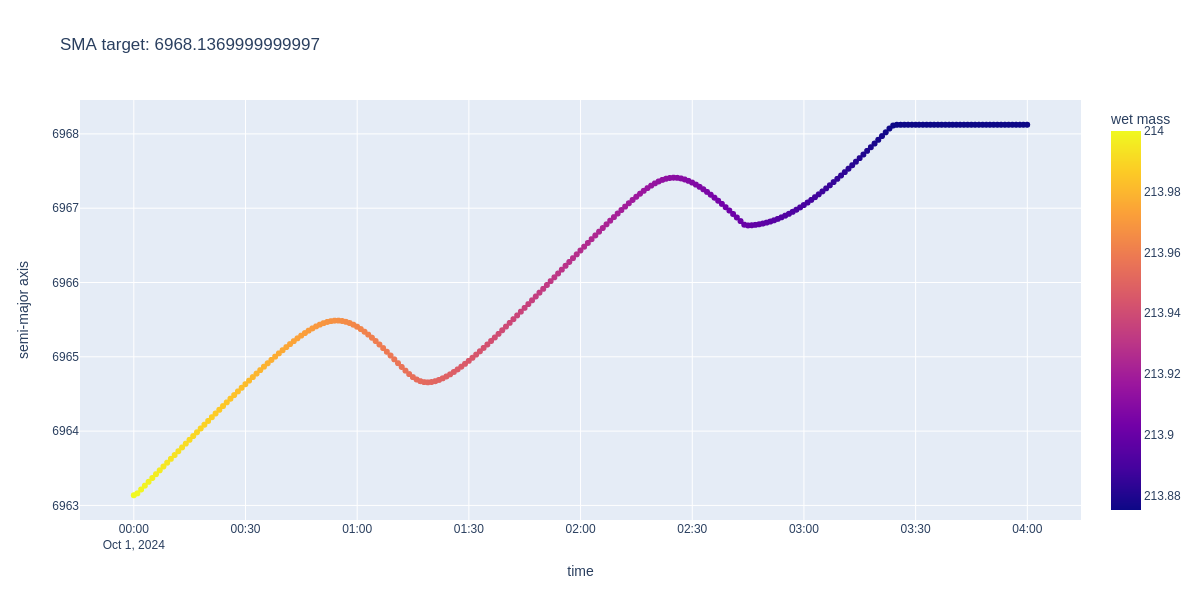

In [33]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="wet mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("png")

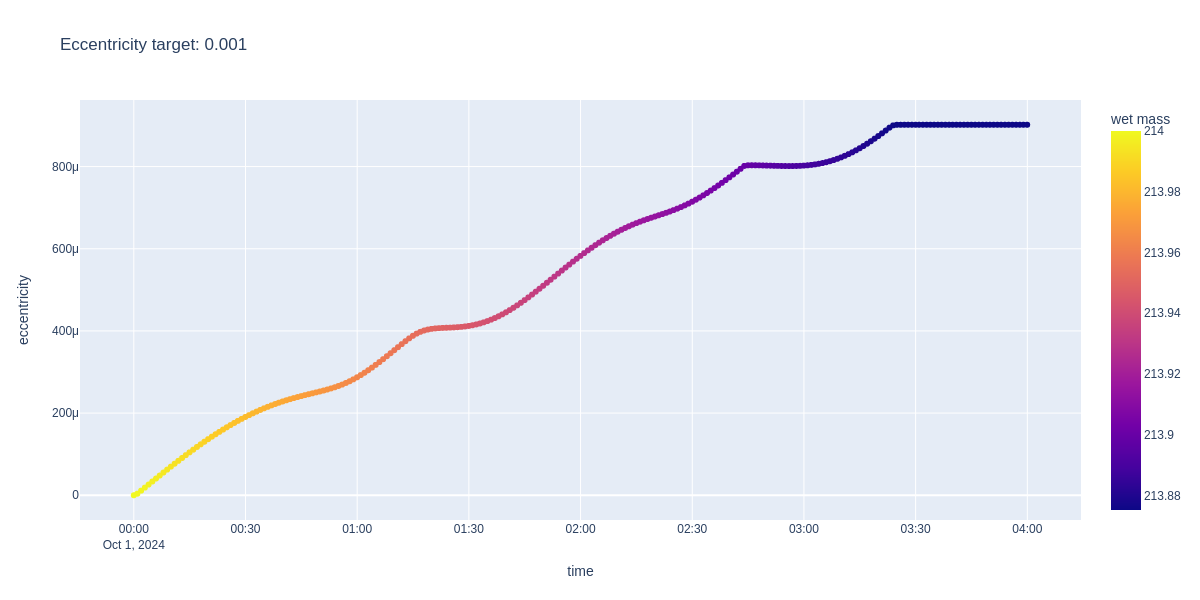

In [34]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="wet mass",
    title=f"Eccentricity target: {target_coe.get_eccentricity()}",
    height=600,
    width=1200,
)
figure.show("png")

### Semi Major Axis + Inclination

In [35]:
# Increasing the COE target SMA as it's osculating
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity(),
    coe.get_inclination() + Angle.degrees(1e-1),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Inclination: (1.0, 1e-5),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [36]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(15.0),
)

In [37]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

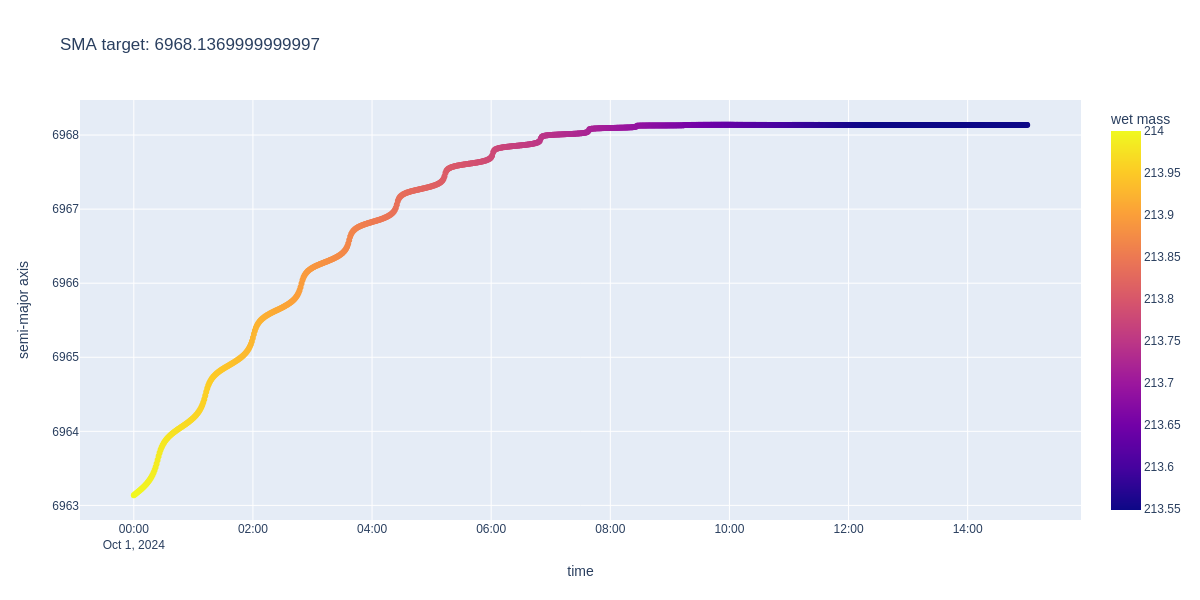

In [38]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="wet mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("png")

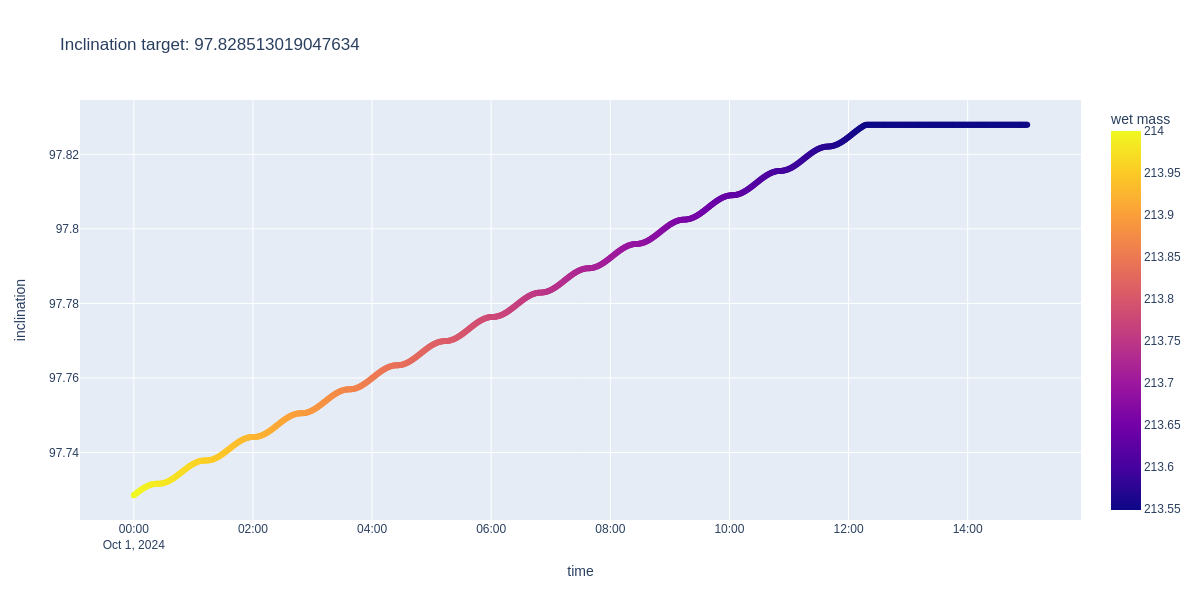

In [39]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="wet mass",
    title=f"Inclination target: {target_coe.get_inclination().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("png")

### SMA + Ecc + Inclination

In [40]:
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity() + 0.001,
    coe.get_inclination() + Angle.degrees(1e-1),
    coe.get_raan(),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-5),
            COE.Element.Inclination: (1.0, 1e-5),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.Analytical,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [41]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(14.0),
)

In [42]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

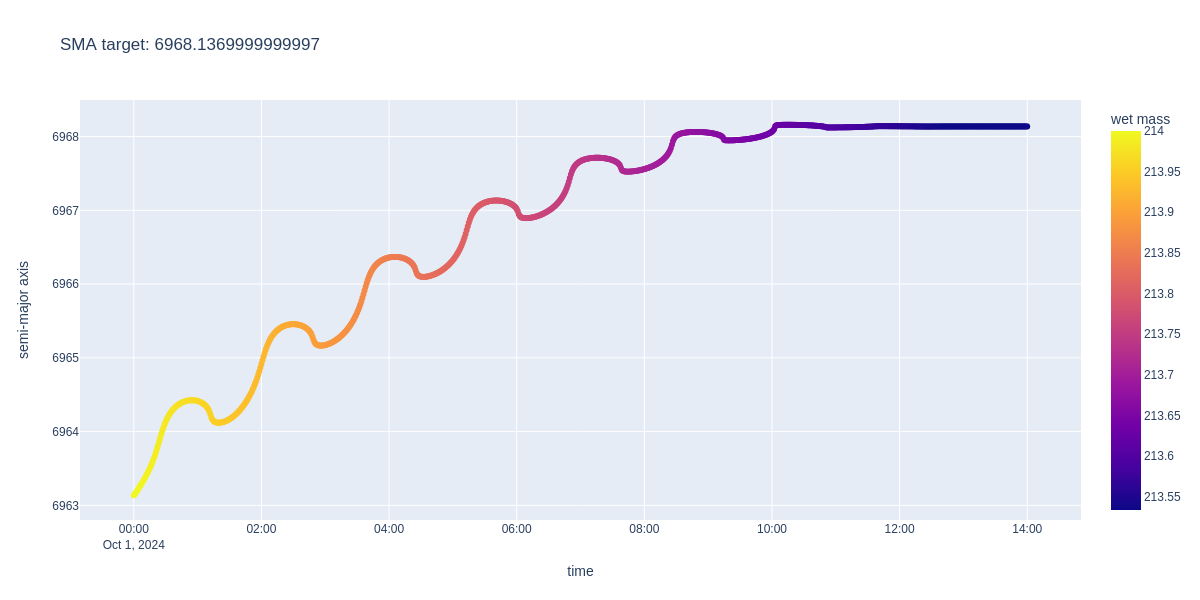

In [43]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="wet mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("png")

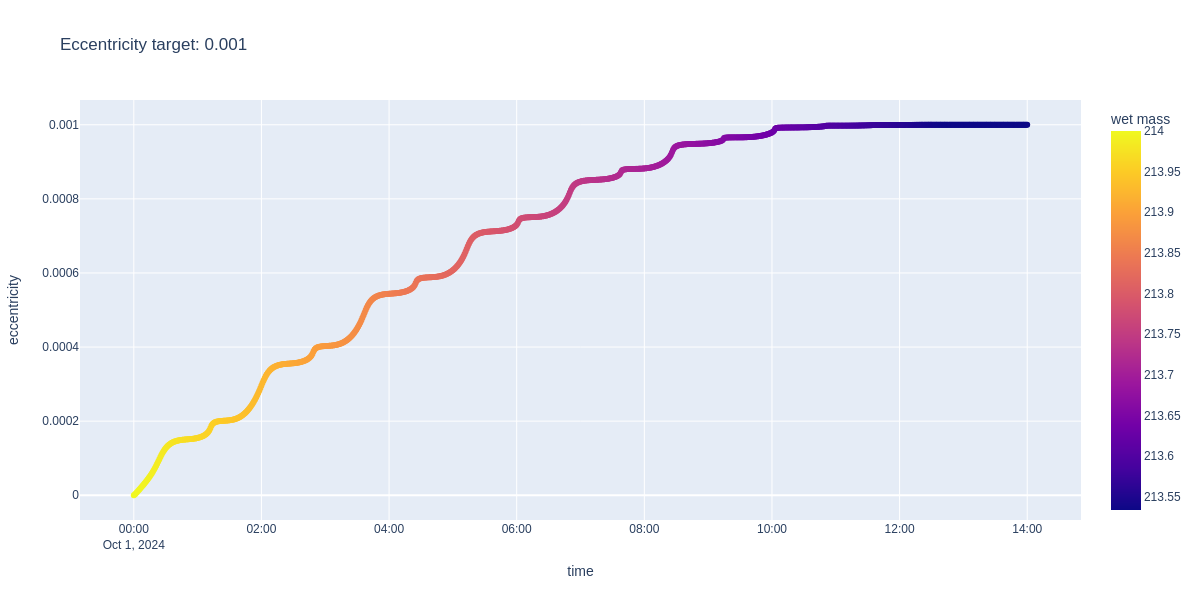

In [45]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="wet mass",
    title=f"Eccentricity target: {target_coe.get_eccentricity()}",
    height=600,
    width=1200,
)
figure.show("png")

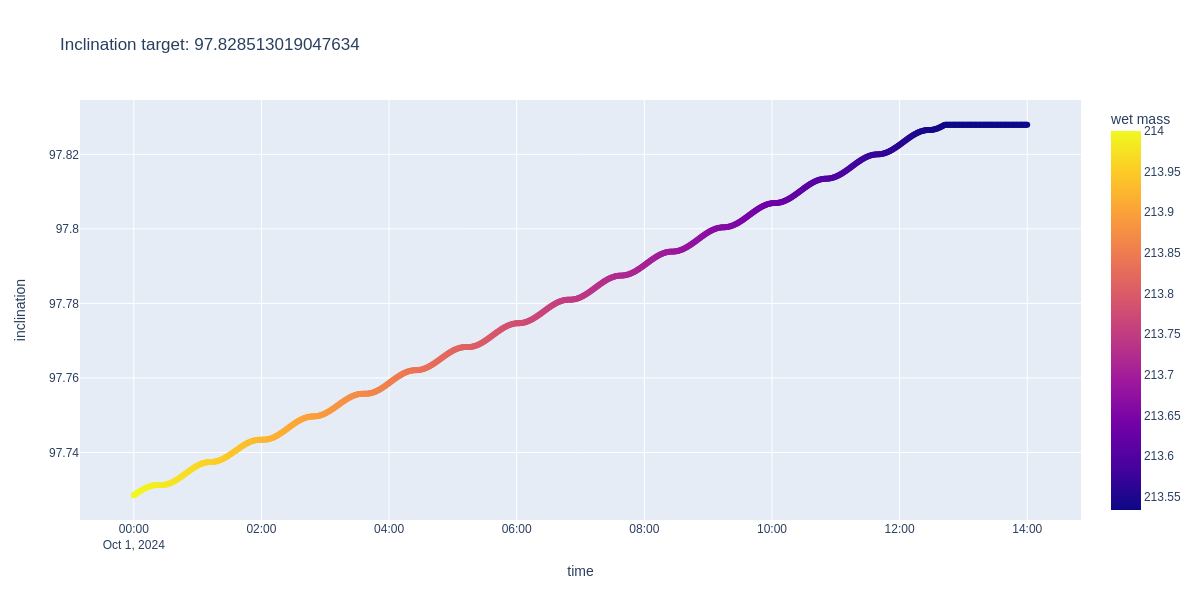

In [46]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="wet mass",
    title=f"Inclination target: {target_coe.get_inclination().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("png")

### SMA + Ecc + Inc + Raan targeting

In [47]:
target_coe = COE(
    coe.get_semi_major_axis() + Length.kilometers(5.0),
    coe.get_eccentricity() + 0.001,
    coe.get_inclination() + Angle.degrees(1e-1),
    coe.get_raan() - Angle.degrees(1e-1),
    coe.get_aop(),
    coe.get_true_anomaly(),
)
guidance_law = QLaw(
    target_coe,
    EarthGravitationalModel.EGM2008.gravitational_parameter,
    QLaw.Parameters(
        element_weights={
            COE.Element.SemiMajorAxis: (1.0, 50.0),
            COE.Element.Eccentricity: (1.0, 1e-5),
            COE.Element.Inclination: (1.0, 1e-5),
            COE.Element.Raan: (1.0, 1e-5),
        },
        m=3,
        n=4,
        r=2,
        k=100,
        minimum_periapsis_radius=Length.kilometers(6575.0),
        b=0.01,
    ),
    QLaw.GradientStrategy.FiniteDifference,
)

dynamics = Dynamics.from_environment(environment) + [
    Thruster(
        satellite_system=satellite_system,
        guidance_law=guidance_law,
    )
]
propagator = Propagator(numerical_solver, dynamics)

In [48]:
end_state = propagator.calculate_state_at(
    propagation_state,
    propagation_state.get_instant() + Duration.hours(24.0),
)

In [49]:
df = df_from_states(propagator.access_numerical_solver().get_observed_states())

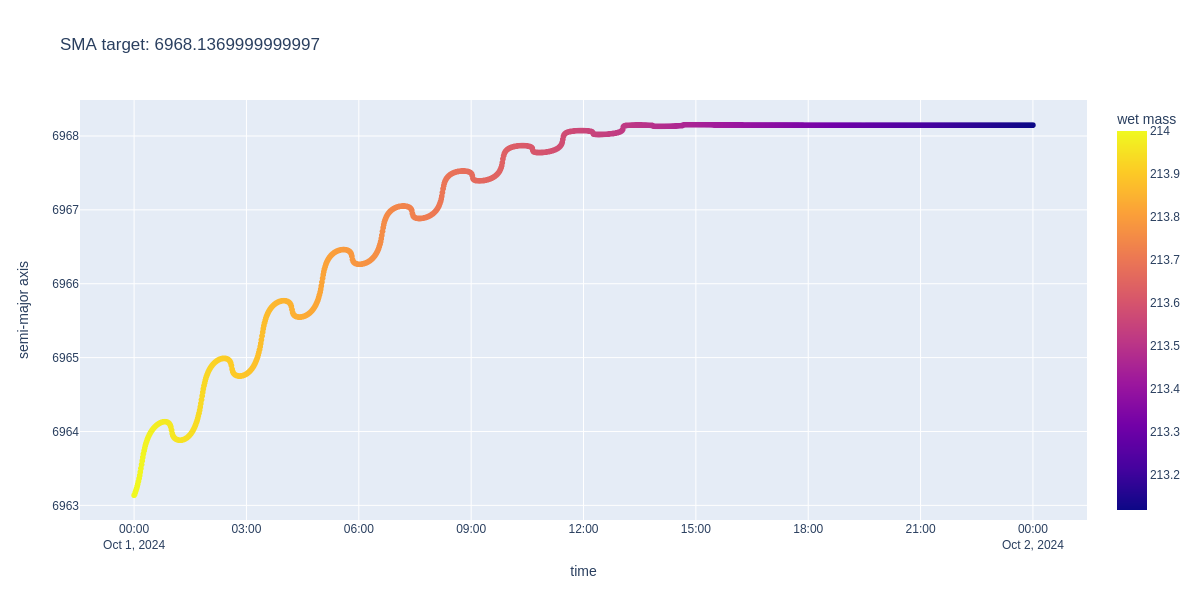

In [50]:
figure = px.scatter(
    df,
    x="time",
    y="semi-major axis",
    color="wet mass",
    title=f"SMA target: {target_coe.get_semi_major_axis().in_kilometers()}",
    height=600,
    width=1200,
)
figure.show("png")

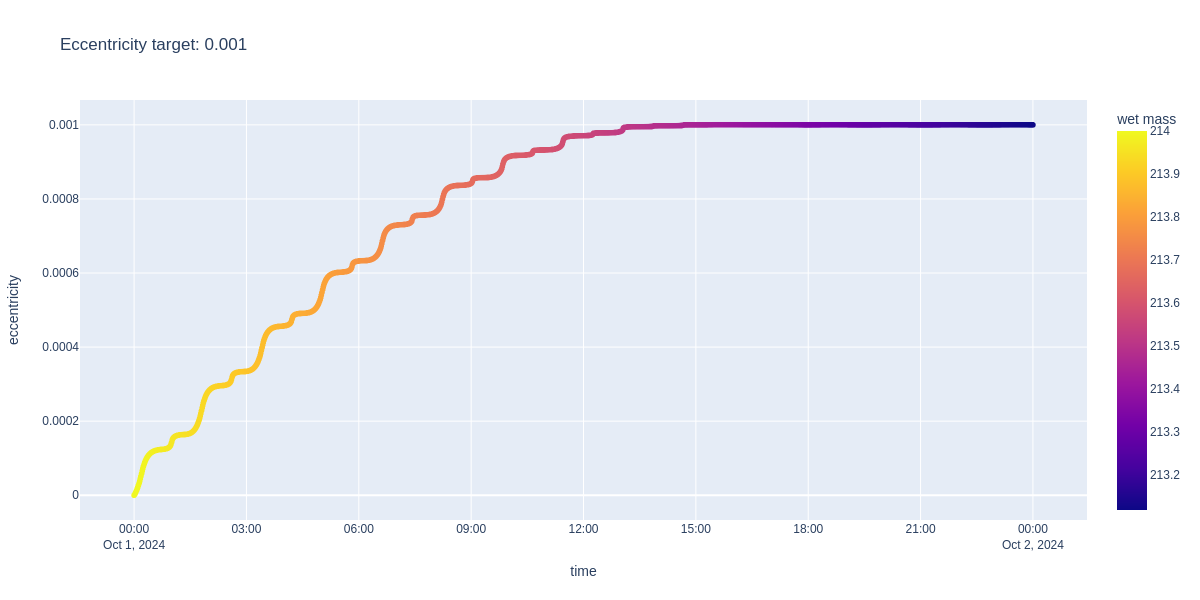

In [51]:
figure = px.scatter(
    df,
    x="time",
    y="eccentricity",
    color="wet mass",
    title=f"Eccentricity target: {target_coe.get_eccentricity()}",
    height=600,
    width=1200,
)
figure.show("png")

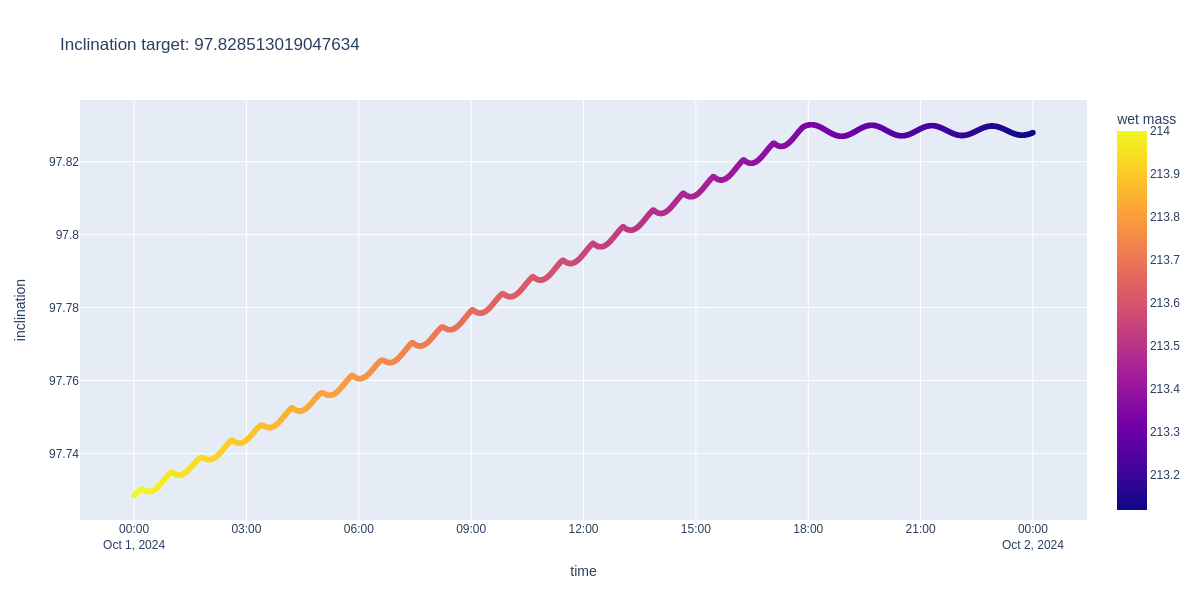

In [52]:
figure = px.scatter(
    df,
    x="time",
    y="inclination",
    color="wet mass",
    title=f"Inclination target: {target_coe.get_inclination().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("png")

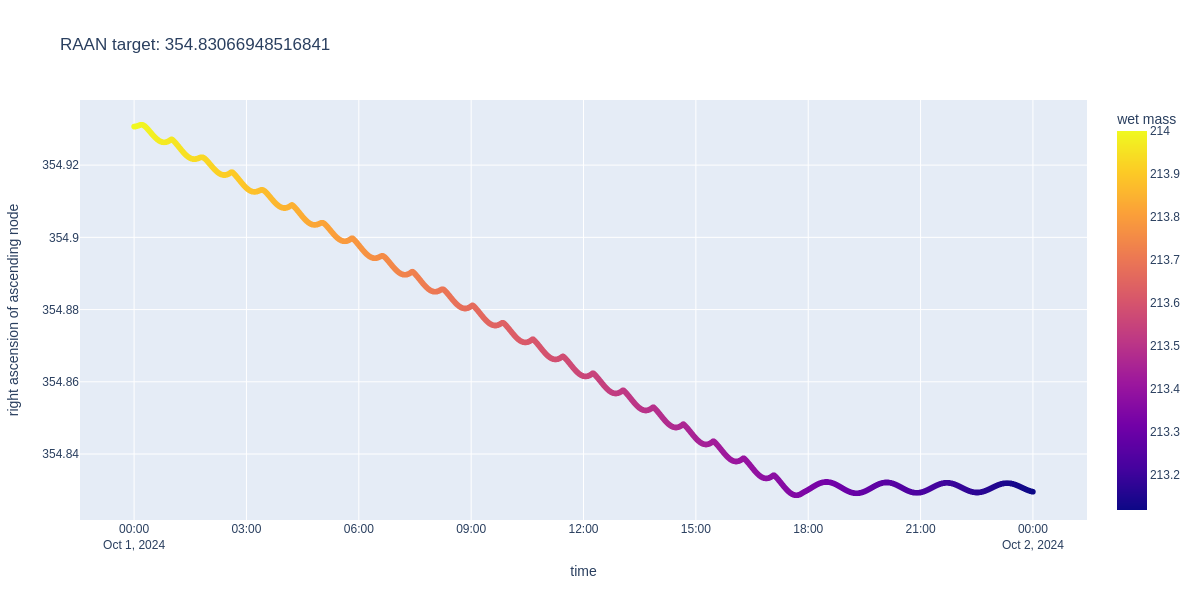

In [ ]:
figure = px.scatter(
    df,
    x="time",
    y="right ascension of ascending node",
    color="wet mass",
    title=f"RAAN target: {target_coe.get_raan().in_degrees()}",
    height=600,
    width=1200,
)
figure.show("png")

---